In [1]:
import os
from datetime import date, datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import kurtosis, skew
from scipy.signal import find_peaks

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

import ruptures as rpt

Make sure you download the 7A folder, SurveyResults.xlsx to run this ipynb.

## Feature Extraction

In [2]:
def statistical_features(arr):
    vmin = np.amin(arr)
    vmax = np.amax(arr)
    mean = np.mean(arr)
    std = np.std(arr)
    return vmin, vmax, mean, std

def shape_features(arr):
    skewness = skew(arr)
    kurt = kurtosis(arr)
    return skewness, kurt

In [3]:
user = '7A'

## Pre-processing

In [4]:


timePointStr = '1587228286'
import_path = f'{user}'
export_path = f'{user}'

rightEDAdatapath  = f'{import_path}/{import_path}_{timePointStr}/EDA.csv'
rightHRdatapath   = f'{import_path}/{import_path}_{timePointStr}/HR.csv'
rightTEMPdatapath = f'{import_path}/{import_path}_{timePointStr}/TEMP.csv'

In [5]:
rightHRdatapath = np.loadtxt(rightHRdatapath, delimiter = ',')
rightHRdatapath = np.repeat(rightHRdatapath, 4)
np.savetxt('hr_new.csv', rightHRdatapath, delimiter = ',')

In [6]:
edat =  pd.read_csv(rightEDAdatapath,  header = 2,  names = ['EDA'])
hrt =   pd.read_csv(f'hr_new.csv',      header = 12, names = ['HR'])
tempt = pd.read_csv(rightTEMPdatapath, header = 2,  names = ['TEMP'])
gt =    pd.read_csv(rightEDAdatapath,  nrows  = 1)

In [7]:
reference_time = int(timePointStr)

In [8]:
from datetime import datetime
from pytz import timezone
timestamp = 1587228286
central = timezone('US/Central')
# dt_object = datetime.fromtimestamp(reference_time + (2*60+8)*60)
dt_object = datetime.fromtimestamp(reference_time + 7310)
dat_cst = dt_object.astimezone(central)

In [9]:
dat_cst

datetime.datetime(2020, 4, 18, 13, 46, 36, tzinfo=<DstTzInfo 'US/Central' CDT-1 day, 19:00:00 DST>)

In [10]:
df_survey = pd.read_excel('SurveyResults.xlsx')
df_survey.head()

,ID,Start time,End time,duration,date,Stress level,COVID related,Treating a covid patient,Patient in Crisis,Patient or patient's family,Doctors or colleagues,"Administration, lab, pharmacy, radiology, or other ancilliary services\n",Increased Workload,Technology related stress,Lack of supplies,Documentation,Competency related stress,Saftey (physical or physiological threats),Work Environment - Physical or others: work processes or procedures,Description
0,5C,08:00:00,09:00:00,01:00:00,2020-04-15,1,0,1,0,1,0,0,0,0,0,0,0,0,0,na
1,5C,17:31:00,17:58:00,00:27:00,2020-04-14,1,0,1,0,1,0,0,1,0,0,0,0,0,0,na
2,E4,15:32:00,15:37:00,00:05:00,2020-04-18,2,0,1,0,1,0,0,0,0,0,0,0,0,0,Spoke with family regarding patient's decline ...
3,E4,14:05:00,14:11:00,00:06:00,2020-04-18,2,0,0,0,1,0,0,0,0,0,0,0,0,0,Was placing another FaceTime call to a patient...
4,7A,13:52:00,14:03:00,00:11:00,2020-04-18,2,0,1,0,0,0,0,1,0,0,0,0,0,1,na


In [11]:
df_survey = df_survey[df_survey['ID'] == user]
df_survey = df_survey.reset_index()

In [12]:
from datetime import datetime
from pytz import timezone
# df_survey.shape[0]
for rowidx in range(df_survey.shape[0]):
    start_time = df_survey.at[rowidx, 'Start time']
    date = df_survey.at[rowidx, 'date']
    end_time = df_survey.at[rowidx, 'End time']
    start_time_date = date+timedelta(hours = start_time.hour, minutes=start_time.minute, seconds=start_time.second)
    end_time_date = date + timedelta(hours = end_time.hour, minutes=end_time.minute, seconds=end_time.second)
    start_timestamp = start_time_date.replace(tzinfo=timezone('US/Central')).timestamp()
    end_timestamp = end_time_date.replace(tzinfo=timezone('US/Central')).timestamp()
    df_survey.loc[rowidx,'Start timestamp'] = start_timestamp
    df_survey.loc[rowidx,'End timestamp'] = end_timestamp
df_survey.to_excel('survey_wTimestamp.xlsx')

In [14]:
from os import listdir
from os.path import isfile, join, isdir, exists
onlydirs = [f for f in listdir('7A') if isdir(join('7A', f))]
onlydirs_clean =[]
# only include directories with enough data and all Temp, EDA, HR and ACC files. 
for dir in onlydirs:
    if exists(user+'/'+dir+'/TEMP.csv') & exists(user+'/'+dir+'/EDA.csv') & exists(user+'/'+dir+'/HR.csv') & exists(user+'/'+dir+'/ACC.csv'):
        if os.path.getsize(user+'/'+dir+'/HR.csv') > 100:
            onlydirs_clean.append(dir)


In [20]:
onlydirs_clean = sorted(onlydirs_clean)

# onlydirs_clean


In [16]:

# onlydirs_clean = ['7A_1587298286']

In [17]:
entireDF = pd.DataFrame()
cols = ['Timestamp','EDA','HR','TEMP','ACC1','ACC2','ACC3','Stress_level']
entireDF = pd.DataFrame(columns=cols)
for dir in onlydirs_clean:
    
    HR = np.loadtxt(user+'/'+dir+'/HR.csv', delimiter = ',')
    HR = np.repeat(HR, 4)
    np.savetxt(user+'/'+dir+'/HR_new.csv', HR, delimiter = ',')

    EDA = np.loadtxt(user+'/'+dir+'/EDA.csv', delimiter = ',')
    EDA = np.repeat(EDA, 1)
    np.savetxt(user+'/'+dir+'/EDA_new.csv', EDA, delimiter = ',')
    
    TEMP = np.loadtxt(user+'/'+dir+'/TEMP.csv', delimiter = ',')
    TEMP = np.repeat(TEMP, 1)
    np.savetxt(user+'/'+dir+'/TEMP_new.csv', TEMP, delimiter = ',')

    ACC = np.loadtxt(user+'/'+dir+'/ACC.csv', delimiter = ',')
    ACC = ACC[::8,:]
    np.savetxt(user+'/'+dir+'/ACC_new.csv', ACC, delimiter = ',')

    edat =  pd.read_csv(user+'/'+dir+'/EDA_new.csv',  header = 4*2,  names = ['EDA'])
    hrt =   pd.read_csv(user+'/'+dir+'/HR_new.csv', header = 4*2, names = ['HR'])
    tempt = pd.read_csv(user+'/'+dir+'/TEMP_new.csv', header = 4*2,  names = ['TEMP'])
    acct = pd.read_csv(user+'/'+dir+'/ACC.csv', header = 2,  names = ['ACC1','ACC2','ACC3'])
    
    min_len = min(len(edat), len(hrt), len(tempt), len(acct))
    eda = edat.iloc[:min_len, 0]
    hr = hrt.iloc[:min_len, 0]
    temp = tempt.iloc[:min_len, 0]
    acc = acct.iloc[:min_len, :]

    timestamp = int(dir[3:])+(np.arange(min_len)/4).astype(int)
    timestamp = pd.DataFrame(timestamp)
    timestamp = timestamp.rename(columns={0: 'Timestamp'})
    date = 
    time = 
    df_temp = pd.concat([timestamp, eda, hr, temp, acc], axis = 1)
    entireDF = entireDF.append(df_temp)

In [18]:
df_survey = pd.read_excel('survey_wTimestamp.xlsx')
for rowidx in range(df_survey.shape[0]):
    event_onset = df_survey.at[rowidx,'Start timestamp']
    event_offset = df_survey.at[rowidx,'End timestamp']
    stresslevel = df_survey.at[rowidx,'Stress level']
    entireDF.loc[(entireDF['Timestamp'] <= event_offset) & (entireDF['Timestamp'] > event_onset),'Stress_level'] = stresslevel
entireDF["Stress_level"] = entireDF["Stress_level"].fillna(0)

In [19]:
# entireDF.head()
entireDF.to_csv('stress_all_sensor_7A_1587298286.csv')

,Timestamp
0,1592926372
1,1592926372
2,1592926372
3,1592926372
4,1592926372
5,1592926372
6,1592926372
7,1592926372
8,1592926372
9,1592926372


In [136]:
dir = onlydirs_clean[0]
timestamp = int(dir[3:])+(np.arange(min_len)/32).astype(int)

In [65]:
(2*60+8)

128

In [48]:
# reference_time = gt.iloc[0,0]

# min_len = min(len(edat), len(hrt))
min_len = min(len(edat), len(hrt), len(tempt))
eda = edat.iloc[:min_len, 0]
hrt = hrt.iloc[:min_len, 0]
tempt = tempt.iloc[:min_len, 0]
df_original = pd.concat([eda, hrt, tempt], axis = 1)
# df_original = pd.concat([eda, hrt], axis = 1)

In [51]:
array = df_original.values
data = pd.DataFrame(array)
data.columns = ['EDA','HR','temp']
# data.columns = ['EDA','HR']

cols = [
    'EDA_Mean','EDA_Min','EDA_Max','EDA_Std', 'EDA_Kurtosis', 'EDA_Skew','EDA_Num_Peaks','EDA_Amphitude','EDA_Duration',
    'HR_Mean','HR_Min','HR_Max','HR_Std','HR_RMS','temp_Mean', 'temp_Min','temp_Max','temp_Std'
]
# cols = [
#     'EDA_Mean','EDA_Min','EDA_Max','EDA_Std', 'EDA_Kurtosis', 'EDA_Skew','EDA_Num_Peaks','EDA_Amphitude','EDA_Duration',
#     'HR_Mean','HR_Min','HR_Max','HR_Std','HR_RMS'
# ]
df_features = pd.DataFrame(columns=cols)

index = 0

for i in range(0,len(data['EDA']), 20):
    df_partial = data.iloc[i:i+40,]
    plen = len(df_partial['EDA'])
    
    if plen < 40:
        continue
    
    eda = df_partial['EDA'].values
    hr = df_partial['HR'].values
    temp = df_partial['temp'].values

    eda_min, eda_max, eda_mean, eda_std = statistical_features(eda)
    hr_min, hr_max, hr_mean, hr_std = statistical_features(hr)
    temp_min, temp_max, temp_mean, temp_std = statistical_features(temp)
    eda_skew, eda_kurtosis = shape_features(eda)
    
    hr_rms = np.sqrt(np.mean(np.square(np.ediff1d(hr))))
    temp_rms= np.sqrt(np.mean(np.square(np.ediff1d(temp))))

    peaks,properties = find_peaks(eda, width=5)
    num_Peaks = len(peaks)
    
    prominences = np.array(properties['prominences'])
    widths = np.array(properties['widths'])
    amphitude = np.sum(prominences)
    duration = np.sum(widths)

    df_features.loc[index] = [eda_mean, eda_min, eda_max, eda_std, eda_kurtosis, eda_skew, num_Peaks, amphitude, duration, hr_mean, hr_min, hr_max, hr_std,hr_rms, temp_mean, temp_min, temp_max, temp_std]

    # df_features.loc[index] = [eda_mean, eda_min, eda_max, eda_std, eda_kurtosis, eda_skew, num_Peaks, amphitude, duration, hr_mean, hr_min, hr_max, hr_std,hr_rms]

    index = index+1

In [10]:
# cols = list(map(str, range(30, 0, -1)))
cols = list(map(str, range(20, 0, -1)))
df_lag_features = pd.DataFrame(columns=cols)
df_lag_features = pd.concat([
    df_features['HR_Mean'].shift(10),  df_features['HR_Mean'].shift(9),    df_features['HR_Mean'].shift(8),
    df_features['HR_Mean'].shift(7),   df_features['HR_Mean'].shift(6),    df_features['HR_Mean'].shift(5),
    df_features['HR_Mean'].shift(4),   df_features['HR_Mean'].shift(3),    df_features['HR_Mean'].shift(2),
    df_features['HR_Mean'].shift(1),  
    # df_features['temp_Mean'].shift(10), df_features['temp_Mean'].shift(9),
    # df_features['temp_Mean'].shift(8), df_features['temp_Mean'].shift(7),  df_features['temp_Mean'].shift(6),
    # df_features['temp_Mean'].shift(5), df_features['temp_Mean'].shift(4),  df_features['temp_Mean'].shift(3),
    # df_features['temp_Mean'].shift(2), df_features['temp_Mean'].shift(1),  
    df_features['EDA_Mean'].shift(10),
    df_features['EDA_Mean'].shift(9),  df_features['EDA_Mean'].shift(8),   df_features['EDA_Mean'].shift(7),
    df_features['EDA_Mean'].shift(6),  df_features['EDA_Mean'].shift(5),   df_features['EDA_Mean'].shift(4),
    df_features['EDA_Mean'].shift(3),  df_features['EDA_Mean'].shift(2),   df_features['EDA_Mean'].shift(1)], axis=1)
df_lag_features.columns = cols
df_lag_features = df_lag_features.dropna()

In [11]:
# df_temp = df_features.iloc[30:3238, 0:31]
# df_total = pd.concat([df_lag_features, df_temp], axis=1)
df_total = pd.concat([df_lag_features], axis=1)

## Stress detection model

In [12]:
df_lag = pd.read_csv('combined_lagEDA.csv')
train_set = df_lag.iloc[:,0:48]
labels = df_lag.iloc[:,48:49]

#Create a random forest Classifier
clf = RandomForestClassifier(n_estimators=100,max_depth=15)

# Split our data
train, test, train_labels, test_labels = train_test_split(train_set, labels, test_size=0.33, random_state=30)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(train, train_labels.values.ravel())

y_pred = clf.predict(test)

f1score   = f1_score        (test_labels, y_pred, average = 'macro')
recall    = recall_score    (test_labels, y_pred, average = 'macro')
precision = precision_score (test_labels, y_pred, average = 'macro')
accuracy  = accuracy_score  (test_labels, y_pred)

print('acc =', accuracy)
print('pre =', precision)
print('recall =', recall) 
print('f1 =', f1score)

acc = 0.9522766009252496
pre = 0.953038607161275
recall = 0.93251298524945
f1 = 0.9413624198172011


In [13]:
from datetime import datetime
from pytz import timezone
timestamp = 1587228286 
central = timezone('US/Central')
dt_object = datetime.fromtimestamp(timestamp)
dat_cst = dt_object.astimezone(central)

In [14]:
dat_cst

datetime.datetime(2020, 4, 18, 11, 44, 46, tzinfo=<DstTzInfo 'US/Central' CDT-1 day, 19:00:00 DST>)

### Predicting the stress

In [15]:
df_total = df_total.dropna()
scalar = MinMaxScaler()
x_scaled = scalar.fit_transform(df_total.iloc[:,0:48])
data = pd.DataFrame(x_scaled)
data = data.fillna(0)

pred_t = clf.predict(data)
pred_t = pd.DataFrame(pred_t)
pred_t.columns=['pred']
pred_t.head(30)
pred_t.to_csv('pred'+user+'.csv')

ValueError: Number of features of the model must match the input. Model n_features is 48 and input n_features is 20 

In [13]:
df_total['pred'] = pred_t
df_total.to_csv('pred{user}.csv')

In [14]:
df_total['MA_3'] = np.ceil(df_total.iloc[:,48:49].rolling(window=31).mean())

### Change detection

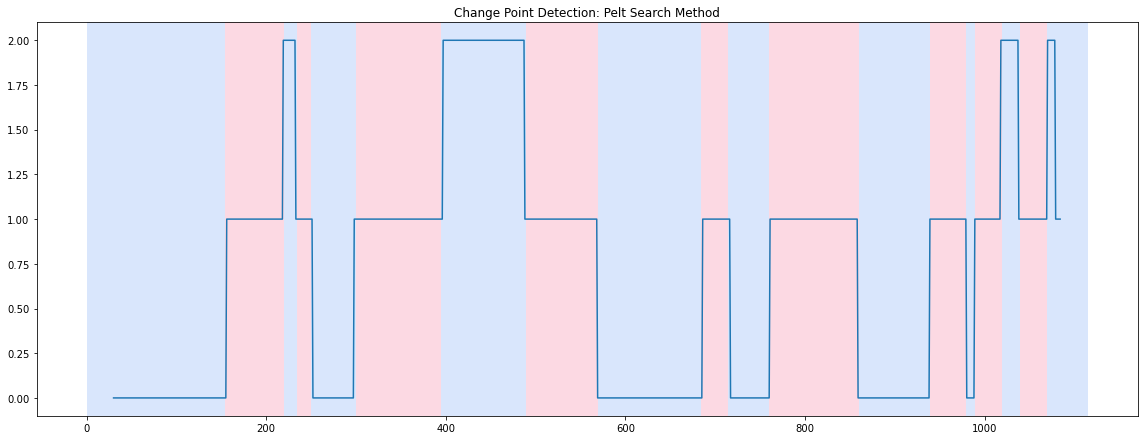

[0, 155, 220, 235, 250, 300, 395, 490, 570, 685, 715, 760, 860, 940, 980, 990, 1020, 1040, 1070, 1115]


In [15]:
signal = df_total.iloc[:,49:50].values

algo = rpt.Window(model="l2", width=10).fit(signal)
result = algo.predict(n_bkps=60)

rpt.display(signal, result, figsize=(16, 6))
plt.title('Change Point Detection: Pelt Search Method')
plt.show()

result.insert(0, 0)
print(result)

### Generating the event by start and end epoch_times

In [16]:
temp_start = 0
temp_end = result[0]

stress = []
for i in range (len(result)-1):
    
    temp = df_total.iloc[result[i]:(result[i+1]-1), 49:50].mean()[0]
    
    if temp > 1.3:
        temp = 2.0
    elif temp >= .65:
        temp = 1
    else:
        temp = 0

    stress.append(temp)
    
df_temp = pd.DataFrame(columns=['start', 'end', 'stress'])
c = 0
for i in range(len(result)-1):
    stressLength = (result[i+1] - result[i]) / 12

    start_point  = result[i]
    end_point    = result[i + 1]
    stress_value = stress[i]
    
    if temp_end <= start_point:
        temp_end       = end_point
        df_temp.loc[c] = [start_point, end_point, stress_value]
        c = c +1

df_temp

,start,end,stress
0,0.0,155.0,0.0
1,155.0,220.0,1.0
2,220.0,235.0,2.0
3,235.0,250.0,1.0
4,250.0,300.0,0.0
5,300.0,395.0,1.0
6,395.0,490.0,2.0
7,490.0,570.0,1.0
8,570.0,685.0,0.0
9,685.0,715.0,1.0


## Change event time to datetime

In [17]:
stress_start = 0
stress_end = 0
tse = 0
previous_stress = -1

for index, row in df_temp.iterrows():

    if row['stress'] == previous_stress:
        stress_end = row['end']
    else:
        if(previous_stress != -1):
            start    = datetime.fromtimestamp(reference_time + (stress_start * 5))
            end      = datetime.fromtimestamp(reference_time + (stress_end * 5))
            timediff = end - start
            print('Prev:', timediff, datetime.fromtimestamp(reference_time + (stress_start * 5)).strftime('%H:%M:%S'), datetime.fromtimestamp(reference_time + (stress_end * 5)).strftime('%H:%M:%S'), previous_stress)
        
        stress_start    = row['start']
        stress_end      = row['end']
        previous_stress = row['stress']
        
print('Final:', timediff, datetime.fromtimestamp(reference_time + (stress_start * 5)).strftime('%H:%M:%S'), datetime.fromtimestamp(reference_time + (stress_end * 5)).strftime('%H:%M:%S'), previous_stress)

Prev: 0:12:55 18:00:04 18:12:59 0.0
Prev: 0:05:25 18:12:59 18:18:24 1.0
Prev: 0:01:15 18:18:24 18:19:39 2.0
Prev: 0:01:15 18:19:39 18:20:54 1.0
Prev: 0:04:10 18:20:54 18:25:04 0.0
Prev: 0:07:55 18:25:04 18:32:59 1.0
Prev: 0:07:55 18:32:59 18:40:54 2.0
Prev: 0:06:40 18:40:54 18:47:34 1.0
Prev: 0:09:35 18:47:34 18:57:09 0.0
Prev: 0:02:30 18:57:09 18:59:39 1.0
Prev: 0:03:45 18:59:39 19:03:24 0.0
Prev: 0:08:20 19:03:24 19:11:44 1.0
Prev: 0:06:40 19:11:44 19:18:24 0.0
Prev: 0:03:20 19:18:24 19:21:44 1.0
Prev: 0:00:50 19:21:44 19:22:34 0.0
Prev: 0:02:30 19:22:34 19:25:04 1.0
Prev: 0:01:40 19:25:04 19:26:44 2.0
Prev: 0:02:30 19:26:44 19:29:14 1.0
Final: 0:02:30 19:29:14 19:32:59 2.0
